# Building Deep Convolutional Networks with TensorFlow

The basic idea of TensorFlow is that you first build up a model with Variables and Constants connected together into a "flow" of functions. Then you run a session which process the whole flow to give a result. You can also use "placeholders" for "input constants" 

In [1]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (2,1))
W = tf.constant([[3., 5.]])
y = tf.matmul(x,W)

with tf.Session() as sess:
    print y.eval(feed_dict={x:[[2.],[4.]]})

[[  6.  10.]
 [ 12.  20.]]


There are many methods defined to help create neural networks following the same principles. When you build the "graph" with all the variables, there are also methods defined to optimize them according to a certain goal.

Let's say we want to make a regression of the type y = ax+b with some data points

/home/adrien/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


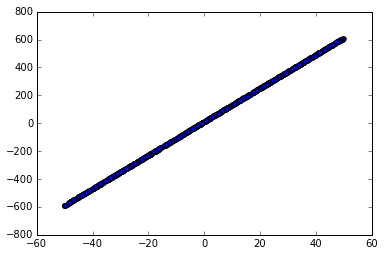

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# y = 12x + 5 + random noise
data_x = np.random.random((1000,1))*100 - 50
data_y = data_x*12 + 5 + np.random.random((1000,1))*2-1

plt.scatter( data_x, data_y )
plt.show()

In [3]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 1]) # None means that it can take any number of input points

a = tf.Variable(tf.random_normal([1,1]))
b = tf.Variable(tf.random_normal([1]))

y = tf.matmul(x, a)+b # the "model" : y = ax + b
print y

target = tf.placeholder(tf.float32, [None,1])
cost = tf.reduce_sum(tf.square(target-y)) # cost function : sum on all training set of (target-y)²

opt = tf.train.AdamOptimizer(1e-2).minimize(cost) # objective : minimize the cost
print opt

Tensor("add:0", shape=TensorShape([Dimension(None), Dimension(1)]), dtype=float32)
name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



Initial values of model : y = 0.937362x + -0.907288
Final values of model : y = 11.998718x + 5.003250


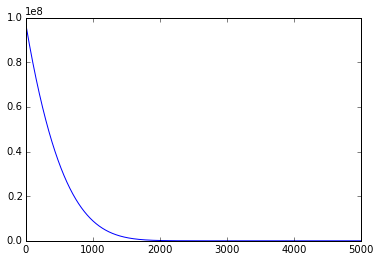

In [4]:
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    print "Initial values of model : y = %fx + %f"%(a.eval(), b.eval())
    
    # iterate the optimizer
    cost_over_time = []
    for i in xrange(5000):
        opt.run(feed_dict={x:data_x, target:data_y})
        cost_over_time.append(cost.eval(feed_dict={x:data_x, target:data_y}))
    
    print "Final values of model : y = %fx + %f"%(a.eval(), b.eval())
    plt.plot(cost_over_time)
    plt.show()

After that, it's just a matter of putting it all together to create the model we want. To make it all easier, we define the helper functions to create layers of a deep model. Each layer will take an input *x*, and produce an output *h*. It may have variable weights and biases. We also have helper functions to initialize the weights. We have a very simple Network class putting everything together.

In [5]:
from NetworkLayer import *
from WeightInit import WeightInit

In [95]:
class Network():
    def __init__(self, inputLayer, hiddenLayers, outputLayer):
        self.layers = []
        self.x = inputLayer.x
        
        inputLayer.link()
        self.layers.append(inputLayer)

        curx = inputLayer.h
        for hl in hiddenLayers:
            hl.link(curx)
            self.layers.append(hl)
            curx = hl.h
            print curx

        outputLayer.link(curx)
        self.layers.append(outputLayer)
        self.y = outputLayer.h
    
    def setupTrainingForClassification(self, costFunction="cross-entropy", optimizer="Adam"):
        self.target = tf.placeholder(tf.float32, self.y.get_shape(), "Target")
        if costFunction == "cross-entropy":
            self.cost = -tf.reduce_sum(self.target*tf.log(self.y))
        elif costFunction == "squared-diff":
            self.cost = tf.reduce_mean(tf.square(self.target-self.y))
        
        if optimizer == "Adam":
            self.trainingStep = tf.train.AdamOptimizer(1e-4).minimize(self.cost)
        elif optimizer == "GradientDescent":
            self.trainingStep = tf.train.GradientDescentOptimizer(0.01).minimize(self.cost)
        self.correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.target,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))
    
    def train(self, x, y):
        self.trainingStep.run(feed_dict={self.x: x, self.target: y})
    
    def evaluate(self, x, y):
        return self.accuracy.eval(feed_dict={self.x: x, self.target: y})
    
    def predict(self, x):
        return self.y.eval(feed_dict={self.x: x})

With that, we can create complex models in a few lines of code.
For instance, we define here a model taking as input a flattened vector from the 28x28 images of the MNIST digits database. It then has a 1000 neurons hidden layer, and another 200 neurons hidden layers, both fully connected with a tanh activation function.
The last layer is a softmax classification layer with ten classes (0-9)

In [96]:
FullyConnectedNetworkDefinition = {
    'inputLayer' : FlatInputLayer(784),
    'hiddenLayers' : [
        FullyConnectedLayer(784,1000,WeightInit.truncatedNormal,WeightInit.positive,tf.nn.tanh),
        FullyConnectedLayer(1000,200,WeightInit.truncatedNormal,WeightInit.positive,tf.nn.tanh)
    ],
    'outputLayer' : FullyConnectedLayer(200,10,WeightInit.truncatedNormal,WeightInit.positive,tf.nn.softmax)
}

Tensor("Tanh_12:0", shape=TensorShape([Dimension(None), Dimension(1000)]), dtype=float32)
Tensor("Tanh_13:0", shape=TensorShape([Dimension(None), Dimension(200)]), dtype=float32)
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.08
step 1000, training accuracy 0.92
step 2000, training accuracy 0.96
step 3000, training accuracy 0.98
step 4000, training accuracy 1
step 5000, training accuracy 0.94
step 6000, training accuracy 0.98
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 0.98
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 0.98
step 13000, training accuracy 1
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 1
step 17000, training accuracy 1
step 18000, training accuracy 1
step 190

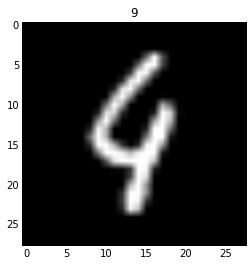

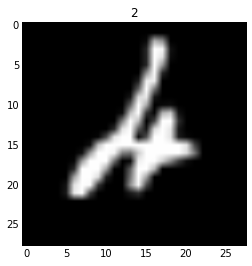

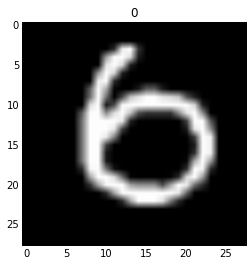

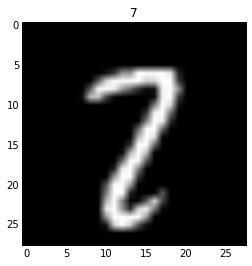

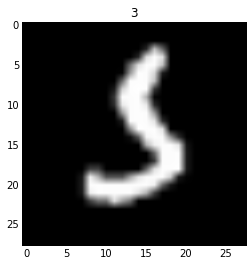

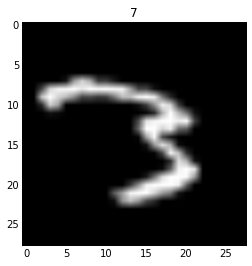

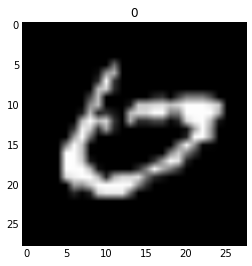

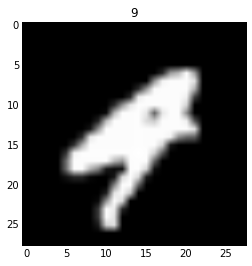

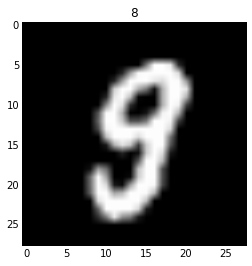

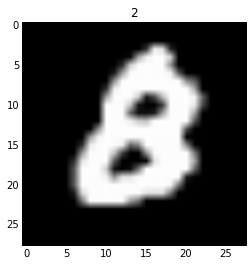

In [89]:
import MNISTData # Helper functions to read the MNIST dataset

model = FullyConnectedNetworkDefinition
net = Network(model['inputLayer'], model['hiddenLayers'], model['outputLayer'])
net.setupTrainingForClassification("cross-entropy", "Adam")

init = tf.initialize_all_variables()
mnist = MNISTData.read_data_sets('MNIST_data', one_hot=True)

with tf.Session() as sess:
    sess.run(init)
    
    # Training
    for i in range(20000):
        batch_xs, batch_ys = mnist.train.next_batch(50)
        if i%1000 == 0:
            acc = net.evaluate(batch_xs, batch_ys)
            print "step %d, training accuracy %g"%(i,acc)
        
        net.train(batch_xs, batch_ys)
    
    print "Test accuracy %g"%net.evaluate(mnist.test.images, mnist.test.labels)
    
    # Showing a few example of misclassified digits
    for i in range(500):
        y = net.predict([mnist.test.images[i]]).argmax()
        if y != mnist.test.labels[i].argmax():
            plt.figure()
            plt.gray()
            plt.imshow(mnist.test.images[i].reshape([28,28]))
            plt.title(str(y))
    plt.show()

With few modifications, we can also create an auto-encoder, where the cost become a "reconstruction cost". For that, we have to invert all the hidden layers to get back to the original image.

In [6]:
class Network():
    def __init__(self, networkDefinition, objective='classification'):
        inputLayer = networkDefinition['inputLayer']
        hiddenLayers = networkDefinition['hiddenLayers']
        self.objective = objective

        self.layers = []
        self.x = inputLayer.x

        inputLayer.link()
        self.layers.append(inputLayer)
        
        curx = inputLayer.h
        for hl in hiddenLayers:
            hl.link(curx)
            self.layers.append(hl)
            curx = hl.h
            print curx

        if( self.objective == 'classification' ):
            outputLayer = networkDefinition['outputLayer']
            outputLayer.link(curx)
            self.layers.append(outputLayer)
            self.y = outputLayer.h
        elif( self.objective == 'reconstruction' ) :
            for i in range(len(self.layers)-1):
                decodingLayer = InvertedLayer(self.layers[len(self.layers)-i-1])
                decodingLayer.link(curx)
                curx = decodingLayer.h
                print curx
            self.y = curx

    def setupTraining(self, costFunction="cross-entropy", optimizer="Adam"):
        self.target = tf.placeholder(tf.float32, self.y.get_shape(), "Target")
        if costFunction == "cross-entropy":
            self.cost = -tf.reduce_sum(self.target*tf.log(self.y))
        elif costFunction == "squared-diff":
            self.cost = tf.reduce_mean(tf.square(self.target-self.y))
        
        if optimizer == "Adam":
            self.trainingStep = tf.train.AdamOptimizer(1e-4).minimize(self.cost)
        elif optimizer == "GradientDescent":
            self.trainingStep = tf.train.GradientDescentOptimizer(0.01).minimize(self.cost)
        
        if(self.objective == 'classification' ):
            self.correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.target,1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))
        elif( self.objective == 'reconstruction' ):
            self.accuracy = (1-self.cost)
    
    def train(self, x, y):
        if( self.objective == 'reconstruction' ):
            y = x
        self.trainingStep.run(feed_dict={self.x: x, self.target: y})
    
    def evaluate(self, x, y):
        if( self.objective == 'reconstruction' ):
            y = x
        return self.accuracy.eval(feed_dict={self.x: x, self.target: y})
    
    def predict(self, x):
        return self.y.eval(feed_dict={self.x: x})

Tensor("Tanh_8:0", shape=TensorShape([Dimension(None), Dimension(1000)]), dtype=float32)
Tensor("Tanh_9:0", shape=TensorShape([Dimension(None), Dimension(200)]), dtype=float32)
Tensor("Tanh_10:0", shape=TensorShape([Dimension(None), Dimension(1000)]), dtype=float32)
Tensor("Tanh_11:0", shape=TensorShape([Dimension(None), Dimension(784)]), dtype=float32)
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.431387
step 10000, training accuracy 0.906525
step 20000, training accuracy 0.909116
step 30000, training accuracy 0.910536
step 40000, training accuracy 0.919406
step 50000, training accuracy 0.916203
step 60000, training accuracy 0.918668
step 70000, training accuracy 0.915676
step 80000, training accuracy 0.917601
step 90000, training accuracy 0.915312
Test accuracy 0.920754


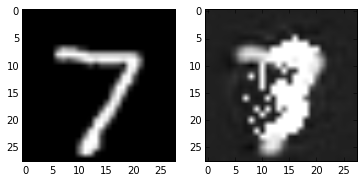

In [9]:
import MNISTData # Helper functions to read the MNIST dataset
from AutoEncoderNetwork import AutoEncoderNetworkDefinition as model

net = Network(model, 'reconstruction')
net.setupTraining("squared-diff", "Adam")

init = tf.initialize_all_variables()
mnist = MNISTData.read_data_sets('MNIST_data', one_hot=True)

sess = tf.Session()

with tf.Session() as sess:
    sess.run(init)
    
    # Training
    for i in range(100000):
        batch_xs, batch_ys = mnist.train.next_batch(50)
        if i%10000 == 0:
            acc = net.evaluate(batch_xs, batch_ys)
            print "step %d, training accuracy %g"%(i,acc)
        
        net.train(batch_xs, batch_ys)
    
    print "Test accuracy %g"%net.evaluate(mnist.test.images, mnist.test.labels)
    
    # Showing an example of reconstruction
    plt.figure(1)
    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(mnist.test.images[0].reshape((28,28)))
    plt.subplot(1,2,2)
    plt.imshow(net.predict([mnist.test.images[0]]).reshape((28,28)))
    plt.show()